<a href="https://www.kaggle.com/code/oscarm524/ps-s4-ep4-eda-modeling-submission?scriptVersionId=171719858" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Notebook Versions

- Version 1 (03/31/2024)
    * EDA and Baseline modeling 1.0.
    

- Version 2 (04/01/2024)
    * Baseline modeling 1.0 updated.
    
    
- Version 3 (04/03/2024)
    * Baseline modeling 2.0 added.
    
    
- Version 4 (04/08/2024)
    * Baseline modeling 2.0 updated.
    

- Version 5 (04/12/2024)
    * Baseline modeling 3.0 added.


# Loading Libraries

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, ExtraTreesRegressor, VotingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.neural_network import MLPRegressor

import optuna

# Reading Data Files

In [2]:
train = pd.read_csv('../input/playground-series-s4e4/train.csv')
test = pd.read_csv('../input/playground-series-s4e4/test.csv')
submission = pd.read_csv('../input/playground-series-s4e4/sample_submission.csv')

original = pd.read_csv('../input/playgrounds4e04originaldata/Original.csv')

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)
print('The dimension of the original dataset is:', original.shape)

The dimension of the train dataset is: (90615, 10)
The dimension of the test dataset is: (60411, 9)
The dimension of the original dataset is: (4177, 10)


In [3]:
train.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [4]:
test.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
0,90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
1,90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
2,90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
3,90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
4,90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


In [5]:
train.isnull().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
dtype: int64

In [6]:
test.isnull().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
dtype: int64

There are no missing values neither in the `train` or `test` data frames. Next, we check for duplicates.

In [7]:
print(f"There are {sum(train.drop(columns='id').duplicated())} duplicated rows in the train data frame.")

print("\n")
print(f"After dropping the target columns, there are {sum(train.drop(columns=['id', 'Rings']).duplicated())} duplicated rows in the train data frame.")

print("\n")
print(f"There are {sum(test.drop(columns='id').duplicated())} duplicated rows in the test data frame.")

There are 0 duplicated rows in the train data frame.


After dropping the target columns, there are 0 duplicated rows in the train data frame.


There are 0 duplicated rows in the test data frame.


In [8]:
temp_train = train.drop(columns=['id', 'Rings'], axis=1)
temp_test = test.drop(columns='id', axis=1)

inner_join = pd.merge(temp_train, temp_test)
print(f"There are {inner_join.shape[0]} observations that appear in both the train and test data frames.")

There are 0 observations that appear in both the train and test data frames.


# Data Exploration

First, let's start by exploring the distribution of `Rings`, the target variable.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


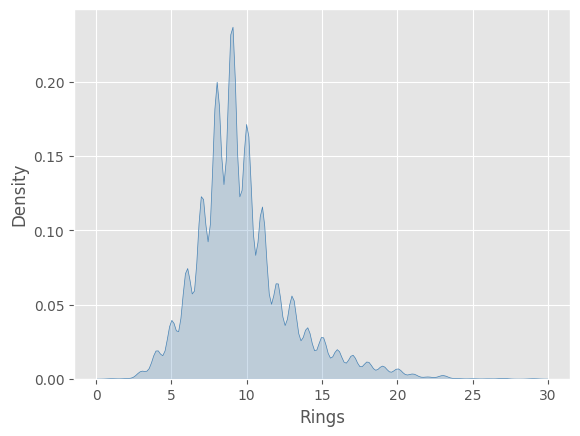

In [9]:
sns.kdeplot(data = train, x = 'Rings', fill = True, color = 'steelblue');

From the above chart, the distribution of `Rings` is right-skewed. 

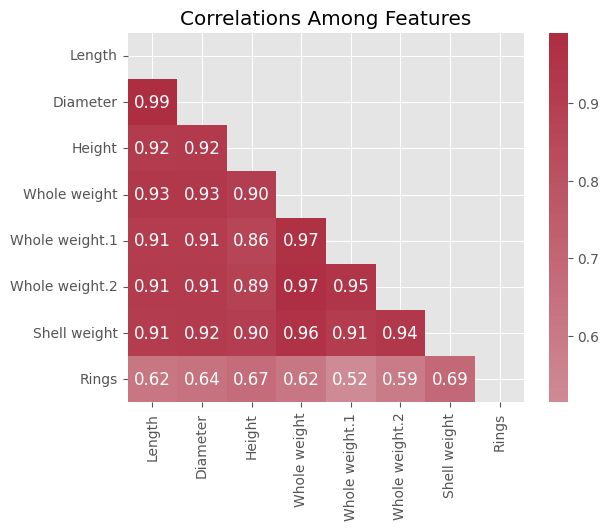

In [10]:
corr_mat_data = train.drop(columns=['id', 'Sex'], axis=1).corr()

data_mask = np.triu(np.ones_like(corr_mat_data, dtype = bool))

cmap = sns.diverging_palette(100, 7, s=75, l=40, n=20, center='light', as_cmap=True)

sns.heatmap(corr_mat_data, annot = True, cmap = cmap, fmt = '.2f', center = 0,
            annot_kws = {'size': 12}, mask = data_mask).set_title('Correlations Among Features');

From the above chart, these are a couple of observations:

- `Shell weight` has the highest correlation with `Rings`.
- `Whole weight.1` has the lowest correlation with `Rings`.
- `Length` and `Diameter` are highly correlated.
- `Shell weight`, `Whole weight`, `Whole weight.1` and `Whole weight.2` are highly correlated.

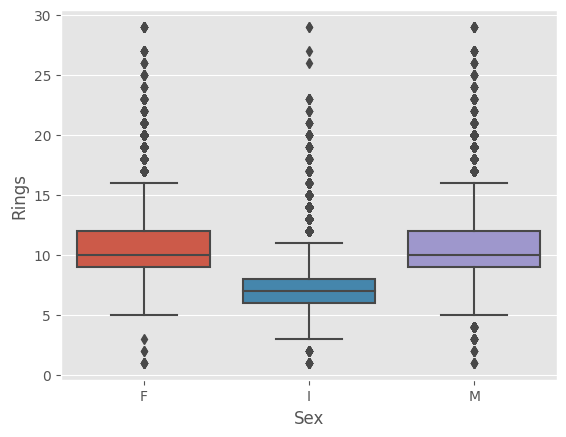

In [11]:
sns.boxplot(data = train, x='Sex', y ='Rings');

From the above side-by-side boxplots, on average the median `Rings` when `Sex=I` is lower.

# Baseline Modeling 1.0

In this section, we train a few standard models with raw data. First, we define the input and target variables. 

In [12]:
X = train.drop(columns=['id', 'Rings'], axis=1)
Y = train['Rings']

X['Sex'] = X['Sex'].map({'I': 0,
                         'F': 1,
                         'M': 2})

skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=42)

First, we train the `HistGradientBoostingRegressor` model

In [13]:
%%time
HB_cv = cross_val_score(HistGradientBoostingRegressor(**{'loss': 'absolute_error',
                                                         'l2_regularization': 0.40450742044665294,
                                                         'early_stopping': False,
                                                         'learning_rate': 0.08127446845453842,
                                                         'max_iter': 790,
                                                         'max_depth': 6,
                                                         'max_bins': 255,
                                                         'min_samples_leaf': 26,
                                                         'max_leaf_nodes': 47,
                                                         'random_state': 10}),
                        X, 
                        Y, 
                        scoring='neg_mean_squared_log_error',
                        cv=skf, 
                        n_jobs=-1)

print(f"The average 10-folds oof MSLE score of the HistGradientBoostingRegressor model is {-1*HB_cv.mean()}")

The average 10-folds oof MSLE score of the HistGradientBoostingRegressor model is 0.023184854136731374
CPU times: user 396 ms, sys: 208 ms, total: 604 ms
Wall time: 1min 3s


Next, we train the `LGBMRegressor` model

In [14]:
%%time
LGBM_cv = cross_val_score(LGBMRegressor(**{'n_estimators': 810,
                                           'learning_rate': 0.03585402410223283,
                                           'max_depth': 18,
                                           'reg_alpha': 2.490687676211329,
                                           'reg_lambda': 5.966931343552022,
                                           'num_leaves': 74,
                                           'subsample': 0.6388852625997685,
                                           'colsample_bytree': 0.5898355526452208,
                                           'verbose': -1}),
                          X, 
                          Y, 
                          scoring='neg_mean_squared_log_error',
                          cv=skf, 
                          n_jobs=-1)

print(f"The average 10-folds oof MSLE score of the LGBMRegressor model is {-1*LGBM_cv.mean()}")

The average 10-folds oof MSLE score of the LGBMRegressor model is 0.022110872643818544
CPU times: user 513 ms, sys: 187 ms, total: 699 ms
Wall time: 1min 28s


Next, we train the `XGBRegressor` model

In [15]:
%%time
XGB_cv = cross_val_score(XGBRegressor(**{'objective': 'reg:absoluteerror',
                                         'tree_method': 'hist',
                                         'max_depth': 15,
                                         'learning_rate': 0.009877874963968103,
                                         'n_estimators': 903,
                                         'gamma': 0.16328424261568497,
                                         'min_child_weight': 8,
                                         'colsample_bytree': 0.7122328529648947,
                                         'subsample': 0.5437785409212837}),
                          X, 
                          Y, 
                          scoring='neg_mean_squared_log_error',
                          cv=skf, 
                          n_jobs=-1)

print(f"The average 10-folds oof MSLE score of the XGBRegressor model is {-1*XGB_cv.mean()}")

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The average 10-folds oof MSLE score of the XGBRegressor model is 0.02259849049678321
CPU times: user 1.89 s, sys: 728 ms, total: 2.62 s
Wall time: 5min 57s


Finally, we train a `VotingRegressor` using the `HistGradientBoostingRegressor`, `LGBMRegressor`, and `XGBRegressor` as the estimators.

In [16]:
%%time
HB_md = HistGradientBoostingRegressor(**{'loss': 'absolute_error',
                                         'l2_regularization': 0.40450742044665294,
                                         'early_stopping': False,
                                         'learning_rate': 0.08127446845453842,
                                         'max_iter': 790,
                                         'max_depth': 6,
                                         'max_bins': 255,
                                         'min_samples_leaf': 26,
                                         'max_leaf_nodes': 47,
                                         'random_state': 10})

LGBM_md = LGBMRegressor(**{'n_estimators': 810,
                           'learning_rate': 0.03585402410223283,
                           'max_depth': 18,
                           'reg_alpha': 2.490687676211329,
                           'reg_lambda': 5.966931343552022,
                           'num_leaves': 74,
                           'subsample': 0.6388852625997685,
                           'colsample_bytree': 0.5898355526452208,
                           'verbose': -1})

XGB_md = XGBRegressor(**{'objective': 'reg:absoluteerror',
                         'tree_method': 'hist',
                         'max_depth': 15,
                         'learning_rate': 0.009877874963968103,
                         'n_estimators': 903,
                         'gamma': 0.16328424261568497,
                         'min_child_weight': 8,
                         'colsample_bytree': 0.7122328529648947,
                         'subsample': 0.5437785409212837})

vot_md = VotingRegressor(estimators=[('HB', HB_md),
                                     ('LGBM', LGBM_md), 
                                     ('XGB', XGB_md)],
                         weights=[0.132792,	0.837411, 0.365622],
                         n_jobs=-1)

vot_cv = cross_val_score(vot_md,
                         X, 
                         Y, 
                         scoring='neg_mean_squared_log_error',
                         cv=skf, 
                         n_jobs=-1)

print(f"The average 10-folds oof MSLE score of the VotingRegressor model is {-1*vot_cv.mean()}")

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The average 10-folds oof MSLE score of the VotingRegressor model is 0.02191984250607198
CPU times: user 2.14 s, sys: 862 ms, total: 3 s
Wall time: 7min 14s


In [17]:
model_performance = pd.DataFrame()
model_performance['Model'] = ['HGB', 'LGBM', 'XGB', 'Voting']
model_performance['10-folds oof MSLE'] = [-1*HB_cv.mean(), -1*LGBM_cv.mean(), -1*XGB_cv.mean(), -1*vot_cv.mean()]
print(f"The followig table shows the performance of the considered models: \n\n{model_performance}")


The followig table shows the performance of the considered models: 

    Model  10-folds oof MSLE
0     HGB           0.023185
1    LGBM           0.022111
2     XGB           0.022598
3  Voting           0.021920


From the above, `VotingRegressor` is the best model. Finally, we train the `VotingRegressor` in the entire dataset.

In [18]:
%%time
vot_fit = vot_md.fit(X, Y)

test_cv = test.drop(columns=['id'], axis=1)
test_cv['Sex'] = test_cv['Sex'].map({'I': 0,
                                     'F': 1,
                                     'M': 2})

submission['Rings'] = vot_fit.predict(test_cv)
submission.head()

CPU times: user 27.5 s, sys: 364 ms, total: 27.9 s
Wall time: 1min 18s


,id,Rings
0,90615,9.986636
1,90616,9.630167
2,90617,9.808552
3,90618,10.423018
4,90619,7.733406


In [19]:
submission.to_csv('baseline_sub_1.csv', index=False)

# Baseline Modeling 2.0

In this section, we focus on the best two models from the baseline modeling 1.0. 

In [20]:
%%time
LGBM_md_1 = LGBMRegressor(**{'n_estimators': 810,
                             'learning_rate': 0.03585402410223283,
                             'max_depth': 18,
                             'reg_alpha': 2.490687676211329,
                             'reg_lambda': 5.966931343552022,
                             'num_leaves': 74,
                             'subsample': 0.6388852625997685,
                             'colsample_bytree': 0.5898355526452208,
                             'verbose': -1})

LGBM_md_2 = LGBMRegressor(**{'n_estimators': 811,
                             'learning_rate': 0.04120282783550326,
                             'max_depth': 11,
                             'reg_alpha': 5.135042437230445,
                             'reg_lambda': 0.9719504157071543,
                             'num_leaves': 55,
                             'max_bin': 251,
                             'subsample': 0.2363976964063146,
                             'colsample_bytree': 0.7791510915507456,
                             'verbose': -1})

step_1 = ColumnTransformer([('interaction', PolynomialFeatures(interaction_only=True), ['Shell weight', 'Whole weight'])])
step_2 = ColumnTransformer([('pass', 'passthrough', ['Sex',	'Length', 'Diameter', 'Height',	'Whole weight.1', 'Whole weight.2'])])
step_3 = FeatureUnion([('step-1', step_1),
                       ('step-2', step_2)])

LGBM_md_3 = Pipeline([('trans', step_3), 
                      ('LGBM', LGBMRegressor(**{'n_estimators': 960,
                                                'learning_rate': 0.024875026444025977,
                                                'max_depth': 8,
                                                'reg_alpha': 8.815022260355498,
                                                'reg_lambda': 0.12049952036942557,
                                                'num_leaves': 86,
                                                'max_bin': 255,
                                                'subsample': 0.29683145617982054,
                                                'colsample_bytree': 0.5876401585129908, 
                                                'verbose': -1}))])


XGB_md_1 = XGBRegressor(**{'objective': 'reg:squaredlogerror',
                           'tree_method': 'hist',
                           'max_depth': 11,
                           'learning_rate': 0.09971637850201594,
                           'n_estimators': 355,
                           'gamma': 0.01806631681074955,
                           'max_bin': 249,
                           'min_child_weight': 3,
                           'colsample_bytree': 0.7682838324873751,
                           'subsample': 0.8708379624829483})

XGB_md_2 = XGBRegressor(**{'objective': 'reg:absoluteerror',
                           'tree_method': 'hist',
                           'max_depth': 11,
                           'learning_rate': 0.015316449891289417,
                           'n_estimators': 948,
                           'gamma': 0.5825397559414278,
                           'max_bin': 243,
                           'min_child_weight': 15,
                           'colsample_bytree': 0.611280896805466,
                           'subsample': 0.3759772274727512})

vot_md = VotingRegressor(estimators=[('LGBM-1', LGBM_md_1),
                                     ('LGBM-2', LGBM_md_2),
                                     ('LGBM-3', LGBM_md_3),
                                     ('XGB-1', XGB_md_1), 
                                     ('XGB-2', XGB_md_2)],
                         weights=[0.187640,	0.353214, 0.449936,	0.251454, 0.429546],
                         n_jobs=-1)

vot_cv = cross_val_score(vot_md,
                         X, 
                         Y, 
                         scoring='neg_mean_squared_log_error',
                         cv=skf, 
                         n_jobs=-1)

print(f"The average 10-folds oof MSLE score of the VotingRegressor model is {-1*vot_cv.mean()}")

The average 10-folds oof MSLE score of the VotingRegressor model is 0.021844388210003035
CPU times: user 9min 42s, sys: 2.87 s, total: 9min 45s
Wall time: 9min 46s


Next, we train the `VotingRegressor` on the entire dataset.

In [21]:
%%time
vot_fit = vot_md.fit(X, Y)

submission['Rings'] = vot_fit.predict(test_cv)
submission.head()

CPU times: user 1min 25s, sys: 277 ms, total: 1min 25s
Wall time: 1min 25s


,id,Rings
0,90615,9.887351
1,90616,9.783265
2,90617,9.844628
3,90618,10.479437
4,90619,7.712259


In [22]:
submission.to_csv('baseline_sub_2.csv', index=False)

# Baseline Modeling 3.0

In this section, we focus on the best two models from the previous section. We also add the original dataset.

In [23]:
train = pd.read_csv('../input/playground-series-s4e4/train.csv')
train['generated'] = 1

original = pd.read_csv('../input/playgrounds4e04originaldata/Original.csv')
original['generated'] = 0
original.columns = train.columns.tolist()

train = pd.concat([train, original], axis=0)

X = train.drop(columns=['id', 'Rings'], axis=1)
Y = train['Rings']

def apply(data):

    out = np.where(data == 'I', 0, 
                   np.where(data == 'F', 1, 2))
    return out


step_4 = ColumnTransformer([('step-4', FunctionTransformer(apply), ['Sex'])])
step_5 = ColumnTransformer([('step-5', 'drop', ['Sex'])], remainder='passthrough')
step_6 = FeatureUnion([('step-4', step_4),
                       ('step-5', step_5)])

LGBM_md_1 = Pipeline([('trans', step_6),
                      ('LGBM', LGBMRegressor(**{'n_estimators': 764,
                                                'learning_rate': 0.06733228660353216,
                                                'max_depth': 6,
                                                'reg_alpha': 4.069383810526775,
                                                'reg_lambda': 8.214128223538179,
                                                'num_leaves': 55,
                                                'subsample': 0.2790819608457388,
                                                'colsample_bytree': 0.8238516508955248,
                                                'verbose': -1}))])

step_1 = ColumnTransformer([('step-1', FunctionTransformer(pd.get_dummies, kw_args={'drop_first':True}), ['Sex'])])
step_2 = ColumnTransformer([('step-2', 'drop', ['Sex'])], remainder='passthrough')
step_3 = FeatureUnion([('step-1', step_1),
                       ('step-2', step_2)])

LGBM_md_2 = Pipeline([('trans', step_3),
                      ('LGBM', LGBMRegressor(**{'n_estimators': 739,
                                                'learning_rate': 0.03516281496222127,
                                                'max_depth': 16,
                                                'reg_alpha': 9.849186761269037,
                                                'reg_lambda': 0.012603134732015134,
                                                'num_leaves': 82,
                                                'subsample': 0.3900552989572896,
                                                'colsample_bytree': 0.5585914686086284,
                                                'verbose': -1}))])

XGB_md_1 = Pipeline([('trans', step_6),
                     ('XGB', XGBRegressor(**{'objective': 'reg:absoluteerror',
                                             'tree_method': 'hist',
                                             'max_depth': 14,
                                             'learning_rate': 0.04658830034960809,
                                             'n_estimators': 999,
                                             'gamma': 2.5806214306066444,
                                             'min_child_weight': 32,
                                             'colsample_bytree': 0.6624263462403435,
                                             'subsample': 0.6841506436293125}))])

XGB_md_2 = Pipeline([('trans', step_6),
                     ('XGB', XGBRegressor(**{'objective': 'reg:squaredlogerror',
                                             'tree_method': 'hist',
                                             'max_depth': 11,
                                             'learning_rate': 0.09975401648986368,
                                             'n_estimators': 711,
                                             'gamma': 0.050250148228158764,
                                             'min_child_weight': 2,
                                             'colsample_bytree': 0.5583674179777528,
                                             'subsample': 0.70028273787386}))])

vot_md = VotingRegressor(estimators=[('LGBM-1', LGBM_md_1),
                                     ('LGBM-2', LGBM_md_2),
                                     ('XGB-1', XGB_md_1), 
                                     ('XGB-2', XGB_md_2)],
                         weights=[0.757945,	0.941906, 0.689726,	0.140368],
                         n_jobs=-1)

vot_md

VotingRegressor(estimators=[('LGBM-1',
                             Pipeline(steps=[('trans',
                                              FeatureUnion(transformer_list=[('step-4',
                                                                              ColumnTransformer(transformers=[('step-4',
                                                                                                               FunctionTransformer(func=<function apply at 0x7b18ade0b640>),
                                                                                                               ['Sex'])])),
                                                                             ('step-5',
                                                                              ColumnTransformer(remainder='passthrough',
                                                                                                transformers=[('step-5',
                                                                                                               'drop',
                                                                                                               ['Sex'])]))])),
                                             ('LGBM',
                                              LGBMRegressor(colsample_bytr...
                                                           learning_rate=0.09975401648986368,
                                                           max_bin=None,
                                                           max_cat_threshold=None,
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=11,
                                                           max_leaves=None,
                                                           min_child_weight=2,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=711,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           objective='reg:squaredlogerror', ...))]))],
                n_jobs=-1, weights=[0.757945, 0.941906, 0.689726, 0.140368])

In [24]:
%%time
test = pd.read_csv('../input/playground-series-s4e4/test.csv')
test['generated'] = 1
test = test.drop(columns='id', axis=1)

vot_md = VotingRegressor(estimators=[('LGBM-1', LGBM_md_1),
                                     ('LGBM-2', LGBM_md_2),
                                     ('XGB-1', XGB_md_1), 
                                     ('XGB-2', XGB_md_2)],
                         weights=[0.757945,	0.941906, 0.689726,	0.140368],
                         n_jobs=-1)

vot_fit = vot_md.fit(X, Y)
submission['Rings'] = vot_fit.predict(test)
submission.head()

CPU times: user 1min 7s, sys: 159 ms, total: 1min 8s
Wall time: 1min 8s


,id,Rings
0,90615,9.809541
1,90616,9.771517
2,90617,9.721336
3,90618,10.340735
4,90619,7.691925


In [25]:
submission.to_csv('baseline_sub_3.csv', index=False)